In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import os

In [15]:

carpeta_co = "Datos_SIATA_Aire_co.json"

with open(carpeta_co, "r", encoding="utf-8") as f:data = json.load(f)

registros = []

        
for estacion in data:
    lat = estacion.get("latitud")
    lon = estacion.get("longitud")
    codigo = estacion.get("codigoSerial")
    nombre = estacion.get("nombre")
    nombreCorto = estacion.get("nombreCorto")
    datos = estacion.get("datos", [])

    for entrada in datos:
        registros.append({
            "codigoSerial": codigo,
            "nombreCorto": nombreCorto,
            "latitud": lat,
            "longitud": lon,
            "contaminante": entrada.get("variableConsulta"),
            "fecha": entrada.get("fecha"),
            "valor": entrada.get("valor"),
            "calidad": entrada.get("calidad")
        })

# Convertimos a DataFrame como antes
df = pd.DataFrame(registros)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df['valor'] = df['valor'].replace(-9999, pd.NA)

print(df.tail(20))


       codigoSerial nombreCorto   latitud   longitud contaminante  \
26263            48    SUR-TRAF  6.152313 -75.627487           co   
26264            48    SUR-TRAF  6.152313 -75.627487           co   
26265            48    SUR-TRAF  6.152313 -75.627487           co   
26266            48    SUR-TRAF  6.152313 -75.627487           co   
26267            48    SUR-TRAF  6.152313 -75.627487           co   
26268            48    SUR-TRAF  6.152313 -75.627487           co   
26269            48    SUR-TRAF  6.152313 -75.627487           co   
26270            48    SUR-TRAF  6.152313 -75.627487           co   
26271            48    SUR-TRAF  6.152313 -75.627487           co   
26272            48    SUR-TRAF  6.152313 -75.627487           co   
26273            48    SUR-TRAF  6.152313 -75.627487           co   
26274            48    SUR-TRAF  6.152313 -75.627487           co   
26275            48    SUR-TRAF  6.152313 -75.627487           co   
26276            48    SUR-TRAF  6

In [16]:
validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)


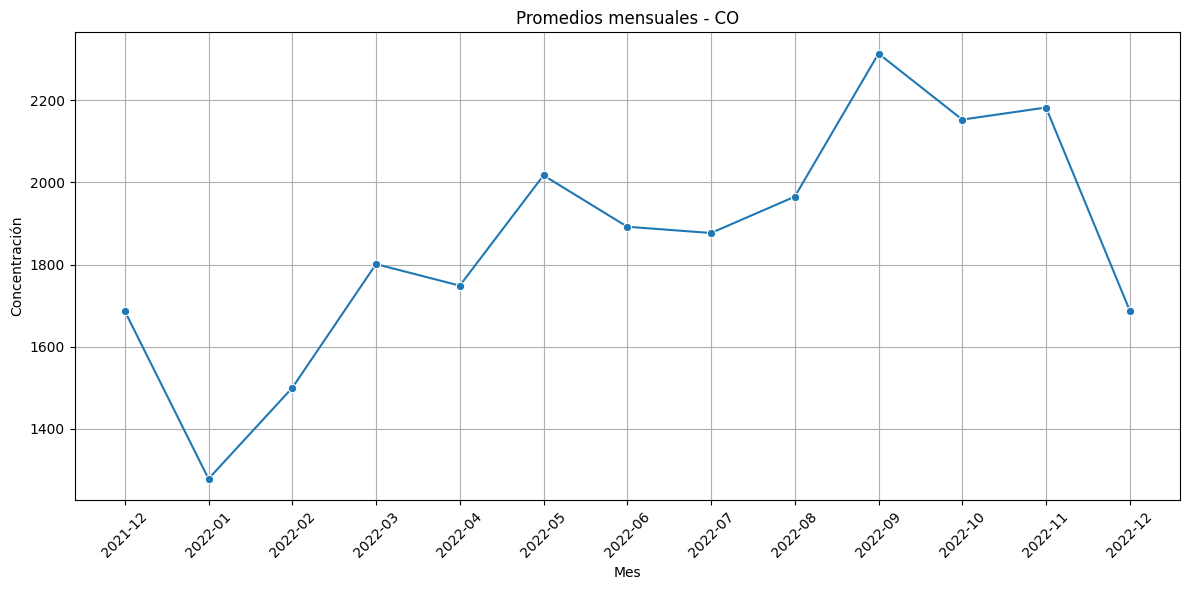

In [18]:
# Obtener contaminante único (ya que el archivo es solo de uno)
contaminante_unico = df['contaminante'].unique()[0] if not df['contaminante'].isna().all() else "Desconocido"
df
df['mes'] = df['fecha'].dt.to_period("M")
promedios_mensuales = df.groupby('mes')['valor'].mean().reset_index()
promedios_mensuales['mes'] = promedios_mensuales['mes'].astype(str)

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
plt.title(f'Promedios mensuales - {contaminante_unico.upper()}')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()